In [1]:
# Environment variables
drive = False
install_packages = False

# If necessary, install packages
if install_packages:
  !pip install Basemap basemap-data-hires
  !pip install pandas matplotlib numpy
  !pip install sklearn
  !pip install datetime

# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from csv import reader
from sklearn.metrics import r2_score
from datetime import datetime
from datetime import timedelta as tdelta
from datetime import time as time
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Mount drive if needed
if drive:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/LSIS

from Helper_funcs import *
from SensorPositions_Func import *
from SVD_Func import *

# Depending on the environemnt, set directory to data
if drive:
  dir_path = '/content/drive/MyDrive/LSIS/data/'
else :
  dir_path = './data/'

folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']
columns_sensors_positions = ['IDs', 'latitude', 'longitude', 'region']

## I. Data import ##

### I.a) Import positions ###

In [2]:
csv_file_name = 'sensor_positions.csv'
coords = []
IDs = []

with open(dir_path + csv_file_name, 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        coord = (float(row[0].split(' ')[0].replace('(', '')), 
                 float(row[0].split(' ')[1].replace(')', '')) )
        coords.append(coord)
        
        IDs.append(row[1])

stations_df = import_sensor_positions(dir_path, csv_file_name)
# stations_df = pd.DataFrame(data={'coords': coords, 'IDs': IDs})
# stations_df.drop_duplicates(subset='IDs', keep='first', inplace=True)
# stations_df.set_index('IDs', inplace=True)
stations_df.set_index('IDs', inplace=True)
IDs = list(stations_df.index)

del csv_file_name, coords, csv_reader, read_obj, row

### I.b) Form groups based on distance between stations ###

In [3]:
groups = make_groups(IDs, stations_df)
stations_df.insert(loc=1, column='grps', value=groups['grp'])

del groups

create groups of sensors based on distance between them


In [4]:
folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']
stations_df['region'] = ''

for folder in folders:
    for file in os.listdir(dir_path + folder):
        sensor_name = file.split('-')[0]
        region = int(folder.split('_')[1])
        stations_df['region'][sensor_name] = region

print(stations_df.head())

       latitude                grps  longitude region
IDs                                                  
2004  24.726405  [2018, 2078, 201D]  59.398497      1
2013  24.748805  [2052, 2360, 2042]  59.434405      2
2015  24.751089  [203D, 2086, 2042]  59.434361      2
2018  24.726473  [2078, 2004, 201D]  59.396803      1
201A  24.744596              [2087]  59.441991      2


### I.c) Import sound pressure values ###

In [5]:
start_time = datetime.strptime('2022.08.01 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.08.13 23:59:00', '%Y.%m.%d %H:%M:%S')

df_data_incomplete = import_sensor_data(dir_path)


del dir_path, file, folder, coord, folders, sensor_name

Append all csv files to a list of dataframes and add the id of the sensor to distinguish them later on

In [6]:
reg4_names = stations_df.index[stations_df['region'] == 4].values
df_data_incomplete = df_data_incomplete[reg4_names]
IDs = df_data_incomplete.columns

### I.d) Get rid of duplicates and fill in missing timestamps ###
-> data is transformed into uniformely sampled data with `np.nan()` in place of missing values
-> start date is 2022.02.20 00:00:00, stop date is 2022.03.05 00:00:00
-> all data is organised into a DataFrame, columns=Sensor IDs, index=Timestamps

## II. Interpolation ##

### II.a) Simple interpolation ###
-> 'nearest'

-> 'linear'

In [7]:
#interpolate data using 'nearest' method

#temp_df = df_data_incomplete.interpolate(method='nearest')
#df_data_nearest = temp_df.interpolate(limit_area=None, method='backfill')
  
#temp_df = df_data_incomplete.interpolate(method='linear')
#df_data_linear = temp_df.interpolate(limit_area=None, method='backfill') 
#df_data_linear.apply(lambda x: np.round(x, 1), 1);


### II.b) Attempts on advanced interpolation ###

#### II.b.1) Raw data separation and filtering ####
-> data is separated into 2 groups: workdays(`df_work_...`), weekenddays(`df_end_...`)

-> average workday (`df_workd_mean`) and average weekend day (`df_endd_mean`) are created by averaging all available data for a specific timestamp of all workdays/weekend days

In [8]:
day_str = datetime.strptime('2023.05.01 00:00:00', '%Y.%m.%d %H:%M:%S')
day_stp = datetime.strptime('2023.05.01 23:59:59', '%Y.%m.%d %H:%M:%S')
daindex = pd.date_range(day_str, day_stp, freq='1min')

df_workd_mean = pd.DataFrame(index=daindex, columns=IDs)
df_endd_mean = pd.DataFrame(index=daindex, columns=IDs)

df_work_all = df_data_incomplete.loc[df_data_incomplete.index.day_of_week < 5].copy()
df_end_all = df_data_incomplete.loc[df_data_incomplete.index.day_of_week > 4].copy()

for moment in daindex:
    idxs_work = df_work_all.index.indexer_at_time(moment.time())
    idxs_end = df_end_all.index.indexer_at_time(moment.time())
    # df_workd_mean - average workday of the station
    df_workd_mean.loc[moment] = df_work_all.iloc[idxs_work].mean()
    # df_endd_mean - average weekend day of the station
    df_endd_mean.loc[moment] = df_end_all.iloc[idxs_end].mean()

del day_stp, day_str, idxs_work, idxs_end, moment

#### II.b.4) Mean-day model interpolation ####
-> mean work and weekend day are expanded into whole available time period for simpler computations

In [9]:

df_mean_ww = df_work_all.copy()
df_mean_we = df_end_all.copy()

for moment in daindex:
    idxs_work = df_work_all.index.indexer_at_time(moment.time())
    idxs_end = df_end_all.index.indexer_at_time(moment.time())
    
    df_mean_ww.iloc[idxs_work] = df_workd_mean.loc[moment]
    df_mean_we.iloc[idxs_end] = df_endd_mean.loc[moment]
    
df_mean = pd.concat([df_mean_we, df_mean_ww], axis=0)
df_mean.sort_index(inplace=True)

del df_mean_ww, df_mean_we, idxs_end, idxs_work, moment, df_work_all, df_end_all

print(df_mean.isna().sum())

21C2    1942
221E    1907
2240    1344
225D    1050
2266    2053
2289    4818
2329    5566
2396    1420
dtype: int64


#### II.b.3) Neighbor data interpolation ####
Missing data is filled with data of neighboring sensors
1) calculate correlation coefficients
    1) for raw data
    2) for average day
2) calculate linear approximation (no offset)
3) approximate missing data (only if raw data available)

In [10]:
# 1.1)
IDs_set = set(IDs);

tdata = [[] for _ in range(len(stations_df.index))]
stations_df['grp_corrs_i'] = tdata
icors = []
ixx = []
iscorr = []

for id in IDs:
    # 1) extract group of sensors
    if id in stations_df.index:
        group = set(stations_df.loc[id]['grps'])
        # 2) filter out non-existing sensors
        group = list(IDs_set & group)
        # 3) extract data
        group_df = df_data_incomplete[group]
        single_df = df_data_incomplete[id]
        stations_df['grps'][id] = group
        corrs = []
        icors = []
        for fid in group:
            # 5) determine lag for precision improvement
            tempc = calculate_correlations(single_df, group_df[fid])
            ttemp = list(np.absolute(tempc))
            itemp = ttemp.index(max(ttemp))
            ttuple = (tempc[itemp], itemp-10, fid)
            corrs.append(ttuple)
            icors.append(max(tempc))
            
        stations_df['grp_corrs_i'][id] = corrs
        ixx.append(id)
        iscorr.append(icors)
        #print(corrs)
try:
  del tempc, ttemp, itemp, ttuple, icors, group, corrs
except:
  pass


In [11]:
stations_df['grp_corrs_i']


IDs
2004    []
2013    []
2015    []
2018    []
201A    []
        ..
23A5    []
23A9    []
23AE    []
23B1    []
23B3    []
Name: grp_corrs_i, Length: 241, dtype: object

In [12]:
# 1.2)
IDs_set = set(IDs);

tdata = [[] for _ in range(len(stations_df.index))]
stations_df['grp_corrs_m']= tdata

mcors = []
mxx = []

mscors = []
msxx = []

for id in IDs:
    # 1) extract group of sensors
    if id in stations_df.index:
        group = set(stations_df.loc[id]['grps'])
        # 2) filter out non-existing sensors
        group = list(IDs_set & group)
        # 3) extract data
        group_df = df_mean[group]
        single_df = df_mean[id]
        stations_df['grps'][id] = group
        corrs = []
        mcors = []
        for fid in group:
            # 5) determine lag for precision improvement
            temp = calculate_correlations(single_df, group_df[fid])
            ttemp = list(np.absolute(temp))
            itemp = ttemp.index(max(ttemp))
            ttuple = (temp[itemp], itemp-10, fid)
            mcors.append(max(temp))
            corrs.append(ttuple)
        stations_df['grp_corrs_m'][id] = corrs
        mxx.append(id)
        mscors.append(mcors)
        #print(corrs)

try:
  del temp, ttemp, itemp, ttuple, mcors, group, corrs
except:
  pass

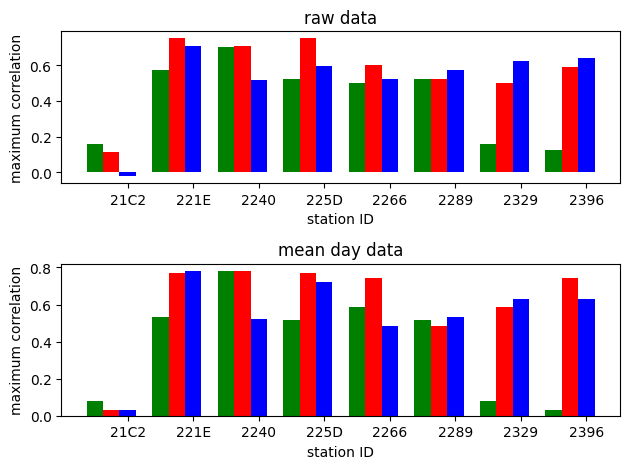

In [13]:
fig, ax = plt.subplots(2,1)

arr0 = []
arr1 = []
arr2 = []
for i in range(0,len(iscorr)):
    if len(iscorr[i]) > 0:
        arr0.append(iscorr[i][0])
    else:
        arr0.append(0)
    
    if len(iscorr[i]) > 1:
        arr1.append(iscorr[i][1])
    else:
        arr1.append(0)
        
    if len(iscorr[i]) > 2:
        arr2.append(iscorr[i][2])
    else:
        arr2.append(0)
        
X = np.arange(len(ixx))

ax[0].set_xlabel('station ID')
ax[0].set_ylabel('maximum correlation')
ax[0].bar(X, arr0, color='r', width = 0.25)
ax[0].bar(X-.25, arr1, color='g', width = 0.25)
ax[0].bar(X+.25, arr2, color='b', width = 0.25, tick_label=ixx)
ax[0].set_title('raw data')

arr0 = []
arr1 = []
arr2 = []
for i in range(0,len(mscors)):
    if len(mscors[i]) > 0:
        arr0.append(mscors[i][0])
    else:
        arr0.append(0)
    
    if len(mscors[i]) > 1:
        arr1.append(mscors[i][1])
    else:
        arr1.append(0)
        
    if len(mscors[i]) > 2:
        arr2.append(mscors[i][2])
    else:
        arr2.append(0)
        
X = np.arange(len(mxx))

ax[1].set_xlabel('station ID')
ax[1].set_ylabel('maximum correlation')
ax[1].bar(X, arr0, color='r', width = 0.25, tick_label=mxx)
ax[1].bar(X - .25, arr1, color='g', width = 0.25, tick_label=mxx)
ax[1].bar(X + .25, arr2, color='b', width = 0.25, tick_label=mxx)
ax[1].set_title('mean day data')

fig.tight_layout()
plt.show()

del X, arr0, arr1, arr2, ixx, mxx, mscors

Raw data clearly shows higher correlation than the averaged one - raw data will be used to fill missing values.

In [14]:
# 2) calculate betas and alphas
   
xx = []
betas = []    
    
IDs_set = set(IDs);

tdata = [[] for _ in range(len(stations_df.index))]
stations_df['grp_linear']= tdata

for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_corrs_i']
        single_df = df_data_incomplete[id]
        beta = []
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            if ftup[0] > .5:
                fid = ftup[2]
                lag = ftup[1]
                group_df = df_data_incomplete[fid]
                tbe, tal = calculate_linear_regression(single_df, group_df, lag)
                ttuple = (tbe, tal, lag, fid)
                beta.append(ttuple)
            
        stations_df['grp_linear'][id] = beta
        xx.append(id)
        betas.append(beta)
try:
  del tbe, tal, ttuple, ftup, fid, lag, xx, beta, betas
except:
  pass

In [15]:
df_data_neighbor = df_data_incomplete.copy()
group_df = pd.DataFrame()
rmses = []
xx = []

# 3) Fill in missing values
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_data_incomplete[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_data_incomplete[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values(single_df, group_df, lags, betas, alphas)  
        df_data_neighbor[id] = df_neighbor_temp
        rmses.append(rmset)
        xx.append(id)

print(df_data_incomplete.isna().sum())
print(df_data_neighbor.isna().sum())

21C2    13388
221E    12356
2240    12190
225D    11967
2266    12866
2289    15536
2329    15939
2396    12362
dtype: int64
21C2    13388
221E     4277
2240     4376
225D     4429
2266     7177
2289     4424
2329    10484
2396     7199
dtype: int64


The values acquired by linear combination of all group stations are compared with original data of main station where possible. Used metric is RMSE

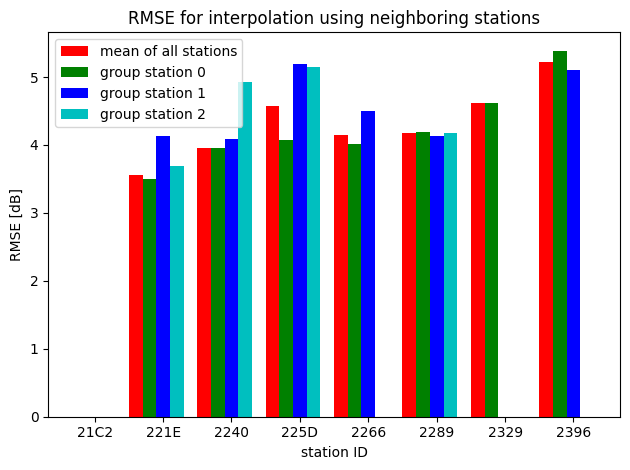

In [16]:
fig, ax = plt.subplots(1,1) 

arr0 = []
arr1 = []
arr2 = []
arr3 = []
for i in range(0,len(rmses)):
    if len(rmses[i]) > 0:
        arr0.append(rmses[i][0])
    else:
        arr0.append(0)
        
    if len(rmses[i]) > 1:
        arr1.append(rmses[i][1])
    else:
        arr1.append(0)
        
    if len(rmses[i]) > 2:
        arr2.append(rmses[i][2])
    else:
        arr2.append(0) 
    if len(rmses[i]) > 3:
        arr3.append(rmses[i][3])
    else:
        arr3.append(0) 
        
X = np.arange(len(xx))

ax.set_xlabel('station ID')
ax.set_ylabel('RMSE [dB]')
ax.bar(X-.30, arr0, color='r', width = 0.20)
ax.bar(X-.10, arr1, color='g', width = 0.20)
ax.bar(X+.10, arr2, color='b', width = 0.20, tick_label=xx)
ax.bar(X+.30, arr3, color='c', width = 0.20)
ax.set_title('RMSE for interpolation using neighboring stations')
ax.legend(['mean of all stations', 'group station 0',
           'group station 1', 'group station 2'])


fig.tight_layout()
plt.show()

try:        
  del xx, rmset, X, arr1, arr2, arr3, arr0
except:
  pass

Since the combination of all members of the group does not always give best results, Kalman fiter assimilation approach is applied where RMSE is used as variance aproximation


In [17]:
df_data_neighbor = df_data_incomplete.copy()
group_df = pd.DataFrame()
rmses1 = []
xx = []

# 3) Fill in missing values
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_data_incomplete[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_data_incomplete[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_data_neighbor[id] = df_neighbor_temp
        rmses1.append(rmset)
        xx.append(id)

try:         
  del beta, alpha, lag, betas, alphas, lags
except:
  pass
#print(df_data_incomplete.isna().sum())
#print(df_data_neighbor.isna().sum())

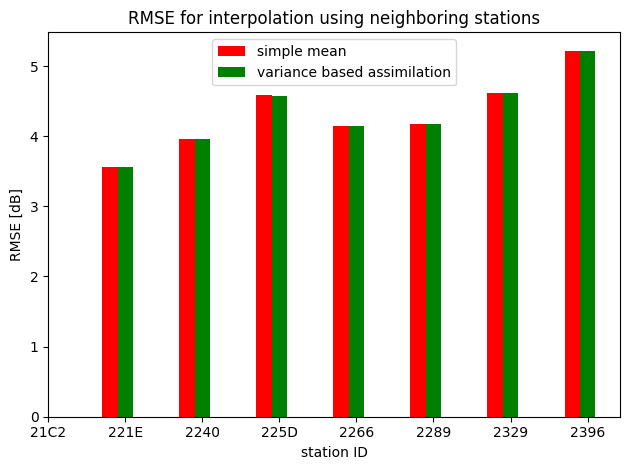

In [18]:
fig, ax = plt.subplots(1,1) 

arr0 = []
arr1 = []
for i in range(0,len(rmses)):
    if len(rmses[i]) > 0:
        arr0.append(rmses[i][0])
    else:
        arr0.append(0)

for i in range(0,len(rmses1)):
    if len(rmses1[i]) > 0:
        arr1.append(rmses1[i][-1])
    else:
        arr1.append(0)
    
        
X = np.arange(len(xx))

ax.set_xlabel('station ID')
ax.set_ylabel('RMSE [dB]')
ax.bar(X-.10, arr0, color='r', width = 0.20)
ax.bar(X+.10, arr1, color='g', width = 0.20, tick_label=xx)
ax.set_title('RMSE for interpolation using neighboring stations')
ax.legend(['simple mean', 'variance based assimilation'])


fig.tight_layout()
plt.show()

try:  
  del rmses, rmses1, msxx, rmset, X, xx, ftup
except:
  pass

Since using assimilation gives less errneous results, it will also be used to fill possible data gaps in mean day models

In [19]:
# 4) Fill in missing values for mean day and weekend
# 4.1) mean weekend
rmses = []
rmses1 = []
xx = []
df_endd_mean_n = df_endd_mean.copy()
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_endd_mean[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_endd_mean[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_endd_mean_n[id] = df_neighbor_temp
        rmses.append(rmset)
        xx.append(id)
        
df_endd_mean_n = df_endd_mean_n.astype('float').interpolate(method='nearest')
df_endd_mean_n = df_endd_mean_n.interpolate(limit_area=None, method='bfill')
df_endd_mean_n = df_endd_mean_n.interpolate(limit_area=None, method='ffill');

try:       
  del beta, alpha, lag, betas, alphas, lags, df_endd_mean
except:
  pass

#print(df_endd_mean.isna().sum())



#print(df_workd_mean.isna().sum())
#print(df_workd_mean_n.isna().sum())

In [20]:
df_workd_mean_n = df_workd_mean.copy()
for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_workd_mean[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_workd_mean[ftup[3]]
        
        df_neighbor_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_workd_mean_n[id] = df_neighbor_temp
        rmses1.append(rmset)
        


df_workd_mean_n = df_workd_mean_n.astype('float').interpolate(method='nearest')
df_workd_mean_n = df_workd_mean_n.interpolate(limit_area=None, method='bfill')
df_workd_mean_n = df_workd_mean_n.interpolate(limit_area=None, method='ffill')

try:
  del beta, alpha, lag, betas, alphas, lags, df_workd_mean, df_neighbor_temp
except:
  pass

#### II.b.4) Mean-day model interpolation ####
-> mean work and weekend day are expanded into whole available time period for simpler computations

In [21]:
df_mean_ww = df_data_incomplete.loc[df_data_incomplete.index.day_of_week < 5].copy()
df_mean_we = df_data_incomplete.loc[df_data_incomplete.index.day_of_week > 4].copy()

for moment in daindex:
    idxs_work = df_mean_ww.index.indexer_at_time(moment.time())
    idxs_end = df_mean_we.index.indexer_at_time(moment.time())
    
    df_mean_ww.iloc[idxs_work] = df_workd_mean_n.loc[moment]
    df_mean_we.iloc[idxs_end] = df_endd_mean_n.loc[moment]
    
df_mean = pd.concat([df_mean_we, df_mean_ww], axis=0)
df_mean.sort_index(inplace=True)

try:
  del df_mean_ww, df_mean_we, idxs_end, idxs_work, moment
except:
  pass

#### II.b.4) Determine resampling period ####

Determine resampling period based on rmse=f(Tresample)

1) for mean interpolation
2) for linear interpolation

The data is downsampled for sampling periods of [1, 2, 5, 10, 15, 20, 30, 60] minutes and rmse is calculated to provide an esimate for information loss

1) no interpolation - simple resampling

9360
9360


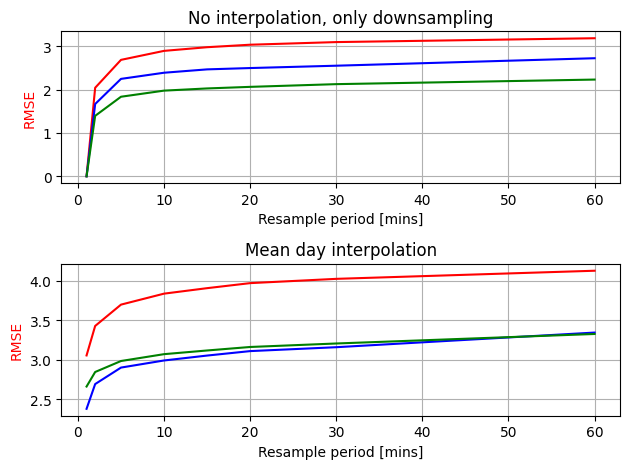

In [22]:
list_rmses = []
resample_pers = [1, 2, 5, 10, 15, 20, 30, 60]
fig, ax = plt.subplots(2,1)


no_interpolation_res = evaluate_resample(df_data_incomplete, df_data_incomplete) 

list_rmses.append(list(no_interpolation_res[0].mean()))
list_rmses.append(list(no_interpolation_res[1].mean()))
list_rmses.append(list(no_interpolation_res[2].mean()))

ax[0] = init_ax_resamp(ax[0], resample_pers, list_rmses)
ax[0].set_title('No interpolation, only downsampling')  

mean_interpolation_res = evaluate_resample(df_data_incomplete, df_mean)
 
list_rmses = []
list_rmses.append(list(mean_interpolation_res[0].mean()))
list_rmses.append(list(mean_interpolation_res[1].mean()))
list_rmses.append(list(mean_interpolation_res[2].mean()))

ax[1] = init_ax_resamp(ax[1], resample_pers, list_rmses)
ax[1].set_title('Mean day interpolation')

fig.tight_layout()
plt.show()

1) mean interpolation - average days

Although simple downsampling shows lower error, it cannot be used, due to missing values. The average day uses larger datasets for computation, which reduces probability of missing datapoints and also offers simple way of updating the model, since each value is basically an average of all values within given time period.

Period of 10mins was chosen due to reasonable precision (compared to other resample periods) and considerable memory savings.

In [23]:
df_mean = df_mean.resample('10T').mean()
df_mean = df_mean.resample('1T').ffill()
df_complete_temp = pd.DataFrame()
df_data_complete = df_data_incomplete.copy()
rmset = []
rmses = []

for id in IDs:
    if id in stations_df.index:
        group_ls = stations_df.loc[id]['grp_linear']
        single_df = df_data_incomplete[id].copy()
        betas = []
        alphas = []
        lags = []
        group_df.drop(columns = group_df.columns, inplace=True)
        for ftup in group_ls:
            # 5) determine lag for precision improvement
            beta = ftup[0]
            alpha = ftup[1]
            lag = ftup[2]
            betas.append(beta)
            alphas.append(alpha)
            lags.append(lag)
            group_df[ftup[3]] = df_data_incomplete[ftup[3]]
            
        betas.append(1)
        alphas.append(0)
        lags.append(0)
        group_df['mean'] = df_mean[id]
        
        df_complete_temp, rmset = fill_missing_values_assim(single_df, group_df, lags, betas, alphas)  
        df_data_complete[id] = df_complete_temp
        rmses.append(rmset)


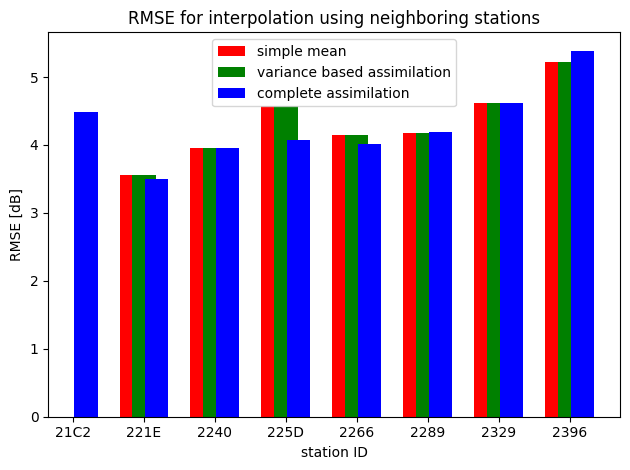

In [24]:
fig, ax = plt.subplots(1,1) 

arr2 = []

for i in range(0,len(rmses)):
    if len(rmses[i]) > 0:
        arr2.append(rmses[i][0])
    else:
        arr2.append(0)
        
X = np.arange(len(xx))

ax.set_xlabel('station ID')
ax.set_ylabel('RMSE [dB]')
ax.bar(X-.18, arr0, color='r', width = 0.33)
ax.bar(X, arr1, color='g', width = 0.33, tick_label=xx)
ax.bar(X+.18, arr2, color='b', width = 0.33)
ax.set_title('RMSE for interpolation using neighboring stations')
ax.legend(['simple mean', 'variance based assimilation', 'complete assimilation'])


fig.tight_layout()
plt.show()

del rmses, rmses1, rmset, X, xx, ftup

In [26]:
df_data_complete = df_data_complete.round(1)
df_data_complete.to_csv('data/' + 'interpolated_data_4.csv')
df_endd_mean_n = df_endd_mean_n.round(1)
df_endd_mean_n.to_csv('data/' + 'mean_endd_4.csv')
df_workd_mean_n = df_workd_mean_n.round(1)
df_workd_mean_n.to_csv('data/' + 'mean_workd_4.csv')

# TESTING #

In [1]:
from Helper_funcs import *
import pandas as pd
dir_path = 'data/'
csv_file_name = 'sensor_positions'

stations_df = import_sensor_positions(dir_path, csv_file_name)

df_mean_workd = pd.read_csv(dir_path + 'mean_workd_4.csv');
tindex = pd.to_datetime(df_mean_workd[df_mean_workd.columns[1]]);
df_mean_workd.set_index(tindex, inplace=True);
df_mean_workd.drop( 'Unnamed: 0', axis = 1, inplace=True);



df_mean_endd = pd.read_csv(dir_path + 'mean_endd_4.csv');
tindex = pd.to_datetime(df_mean_endd[df_mean_endd.columns[1]]);
df_mean_endd.set_index(tindex, inplace=True);
df_mean_endd.drop( 'Unnamed: 0', axis = 1, inplace=True);


reg4_names = stations_df.index[stations_df['region'] == 4].values
df_data_incomplete = import_sensor_data(dir_path)

df_data_incomplete = df_data_incomplete[reg4_names]

NameError: name 'stations_df' is not defined

In [39]:

df_mean1 = mean_model_recon(df_workd_mean_n, df_endd_mean_n, df_data_incomplete.index)

DatetimeIndex(['2022-08-01 00:00:00', '2022-08-01 00:01:00',
               '2022-08-01 00:02:00', '2022-08-01 00:03:00',
               '2022-08-01 00:04:00', '2022-08-01 00:05:00',
               '2022-08-01 00:06:00', '2022-08-01 00:07:00',
               '2022-08-01 00:08:00', '2022-08-01 00:09:00',
               ...
               '2022-08-13 23:50:00', '2022-08-13 23:51:00',
               '2022-08-13 23:52:00', '2022-08-13 23:53:00',
               '2022-08-13 23:54:00', '2022-08-13 23:55:00',
               '2022-08-13 23:56:00', '2022-08-13 23:57:00',
               '2022-08-13 23:58:00', '2022-08-13 23:59:00'],
              dtype='datetime64[ns]', length=18720, freq='T')


In [31]:

del color1, color2, ax, columns_sensors_positions, daindex

In [ ]:
def apply_assimilation(row, vars):
    rmt= vars[row.notna()]
    rmt1 = np.zeros([len(rmt)])
    idxs = np.arange(len(rmt))
    for i in idxs:
        rmt1[i] = np.prod(rmt[idxs != i])

    k_kal = (rmt1) / sum(rmt1)

    row = row.dropna()
    row = row * k_kal
    
    #2 ) return assimilated data
    return row.sum()
ll = np.array(group_df.iloc[5])
coefs = np.array([.1, .3, .5])
apply_assimilation(ll, coefs)

In [ ]:
stations_df['latitude'][IDs[2]]

In [ ]:
df_data_complete = pd.read_csv(dir_path + 'interpolated_data_1.csv');
df_data_complete = df_data_complete.interpolate(method='nearest')
df_data_complete = df_data_complete.interpolate(method='bfill')
df_data_complete = df_data_complete.interpolate(method='ffill')
df_data_complete.isna().sum

In [36]:
sys.modules

NameError: name 'sys' is not defined